# Exploration
Development playground

In [44]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 10

import Quandl
from n472jw.secrets import quandl_api_key
from n472jw.metrics import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


# I. Get Data

In [150]:
#####[ PARAMS ]#####
ticker = 'BIDU'
date_start = pd.datetime(2013, 1, 1)
date_end = pd.datetime(2015, 12, 28)
####################

data = Quandl.get('WIKI/{}'.format(ticker))
data = data[date_start:date_end]
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2013-01-02,103.33,104.75,102.51,104.12,4084800,0,1,103.33,104.75,102.51,104.12,4084800
2013-01-03,104.00,106.90,103.82,104.98,4454400,0,1,104.00,106.90,103.82,104.98,4454400
2013-01-04,104.66,104.86,102.52,104.65,2721900,0,1,104.66,104.86,102.52,104.65,2721900
2013-01-07,102.04,102.57,99.32,102.29,3989900,0,1,102.04,102.57,99.32,102.29,3989900
2013-01-08,102.00,102.76,100.60,101.09,2865300,0,1,102.00,102.76,100.60,101.09,2865300


# Metrics Visualization

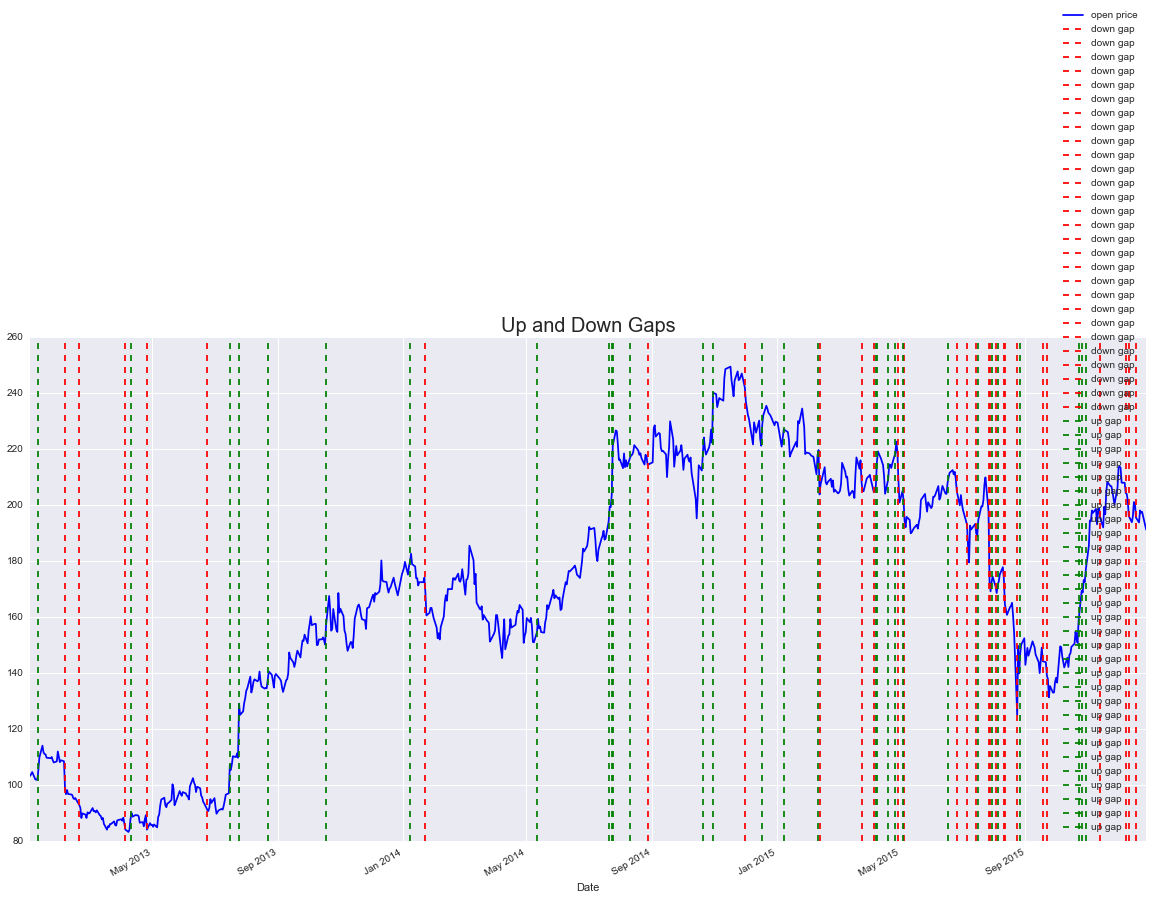

In [151]:
gaps_metric = GapsGetFilled(up_threshold=0.3, down_threshold=0.3)
gaps_metric.plot(data)

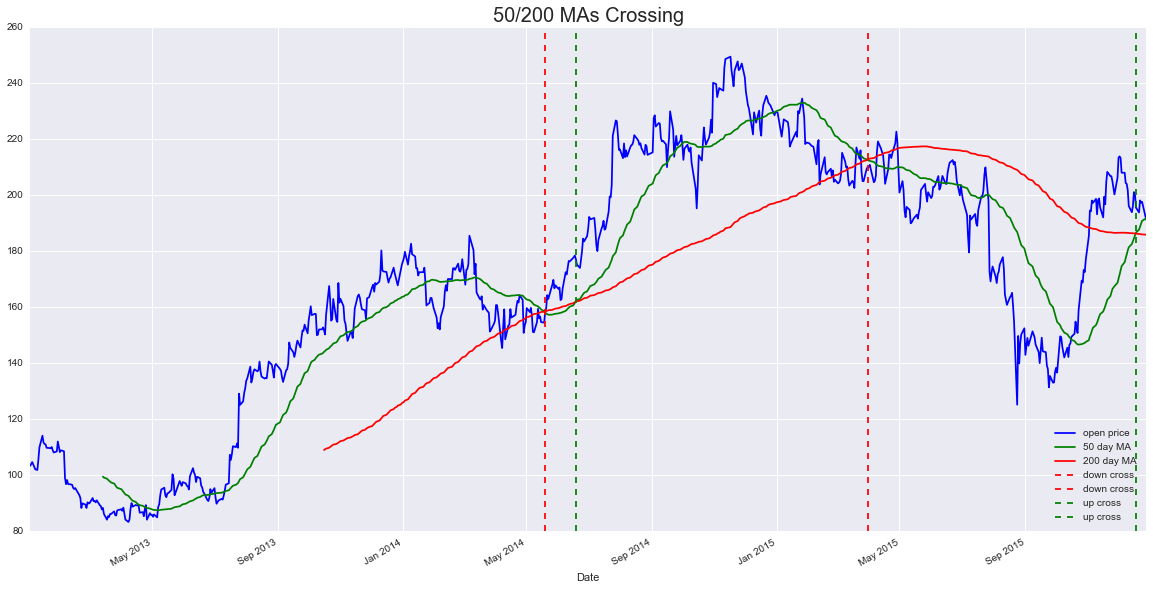

In [152]:
mas_metric = CrossingMovingAverages(ma1=50, ma2=200)
mas_metric.plot(data)

# Metric Evaluation: Gaps Get Filled
- Run the metric
- find periods of a certain length afterwards...
- each metric has it's own evaluation method though... should have a "buy at" and a "sell at"

In [153]:
#####[ PARAMS ]#####
metric = gaps_metric
hold_period = pd.Timedelta('60 days')
####################

#=====[ Step 1: get buy/sell dfs ]=====
buy_series, sell_series = metric.transform(data)

#=====[ Step 2: cut out periods afterwards ]=====
print '=====[ Buy Dates (down gap) ]====='
print 'Buy Date | Price Change over {}'.format(hold_period)
for date, val in buy_series.iterrows():
    df = data[date:date + pd.Timedelta('1 days') + hold_period]
    reaches_goal = df.High.max() >= val.down_gap_sell_price
    if reaches_goal:
        change = df.High.max() - df.iloc[0].Close 
    else:
        change = df.iloc[-1].Close - df.iloc[0].Close
    print date, reaches_goal, change

print 
    
print '=====[ Sell Dates (up gap) ]====='
print 'Sell Date | Price Change over {}'.format(hold_period)
for date, val in sell_series.iterrows():
    df = data[date:date + pd.Timedelta('1 days') + hold_period]
    reaches_goal = df.Low.min() <= val.up_gap_buy_price

    if reaches_goal:
        change = df.Low.min() - df.iloc[0].Open 
    else:
        change = df.iloc[-1].Close - df.iloc[0].Open
    print date, reaches_goal, change    

=====[ Buy Dates (down gap) ]=====
Buy Date | Price Change over 60 days 00:00:00
2013-02-05 00:00:00 False -12.78
2013-02-19 00:00:00 False -5.75
2013-04-05 00:00:00 True 17.09
2013-04-26 00:00:00 True 18.59
2013-06-24 00:00:00 True 53.23
2014-01-23 00:00:00 True 25.76
2014-08-28 00:00:00 True 17.6
2014-12-01 00:00:00 False -18.69
2015-02-12 00:00:00 True 15.73
2015-03-25 00:00:00 True 16.21
2015-04-06 00:00:00 True 20.35
2015-04-30 00:00:00 False -1.2
2015-05-05 00:00:00 True 19.48
2015-06-26 00:00:00 True 6.64
2015-07-06 00:00:00 True 20.97
2015-07-15 00:00:00 True 23.42
2015-07-27 00:00:00 False -63.305
2015-07-28 00:00:00 False -33.645
2015-08-03 00:00:00 True 9.92
2015-08-11 00:00:00 False -23.72
2015-08-12 00:00:00 True 7.69
2015-08-24 00:00:00 True 18.48
2015-09-18 00:00:00 True 62.25
2015-09-22 00:00:00 True 74.78
2015-11-13 00:00:00 True 24.02
2015-12-08 00:00:00 False -12.22
2015-12-11 00:00:00 True 7.62
2015-12-18 00:00:00 True 6.77

=====[ Sell Dates (up gap) ]=====
Sell Da

# Metric Evaluation: Crossing Moving Averages

In [145]:
#####[ PARAMS ]#####
metric = mas_metric
hold_period = pd.Timedelta('30 days')
####################

#=====[ Step 1: get buy/sell dfs ]=====
buy_series, sell_series = metric.transform(data)

#=====[ Step 2: cut out periods afterwards ]=====
print '=====[ Buy Dates (MA1 Crosses Over MA2)  ]====='
print 'Buy Date | Success | Price Change over {}'.format(hold_period)
for date, val in buy_series.iteritems():
    df = data[date:date + pd.Timedelta('1 days') + hold_period]
    change = df.iloc[-1].Close - df.iloc[0].Open
    success = change > 0
    print date, success, change

print '=====[ Sell Dates (MA1 Crossed Under MA2) ]====='
print 'Sell Date | Success | Price Change over {}'.format(hold_period)
for date, val in sell_series.iteritems():
    df = data[date:date + pd.Timedelta('1 days') + hold_period]
    change = df.iloc[-1].Close - df.iloc[0].Open
    success = change < 0
    print date, success, change

=====[ Buy Dates (MA1 Crosses Over MA2)  ]=====
Buy Date | Success | Price Change over 30 days 00:00:00
=====[ Sell Dates (MA1 Crossed Under MA2) ]=====
Sell Date | Success | Price Change over 30 days 00:00:00
2014-10-31 00:00:00 True -12.31
